<a href="https://colab.research.google.com/github/MASSIMOQSELLA/MyAKarpathyMicrogradTest/blob/main/My_first_NN_PDOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Addestramento completato: la loss totale è zero.
Epoch 234, learning rate: 0.0291, total_loss: 0.000000001, iterations: 300

Test della rete neurale:
Input: [0.0, 0.0], Predicted: -0.0000, Actual: 0.0
Input: [0.0, 1.0], Predicted: 1.0000, Actual: 1.0
Input: [1.0, 0.0], Predicted: 1.0000, Actual: 1.0
Input: [1.0, 1.0], Predicted: 0.0000, Actual: 0.0
Input: [2.0, 0.0], Predicted: 1.2000, Actual: 1.2
Input: [2.0, 1.0], Predicted: 1.3000, Actual: 1.3
Input: [2.0, 2.0], Predicted: 1.4000, Actual: 1.4
Input: [0.0, 2.0], Predicted: 1.7000, Actual: 1.7
Input: [3.0, 0.0], Predicted: 3.0000, Actual: 3.0
Input: [3.0, 1.0], Predicted: 0.3100, Actual: 0.31


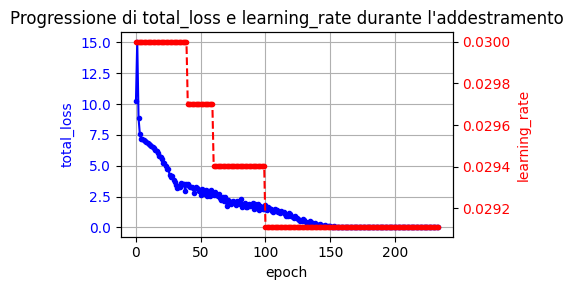

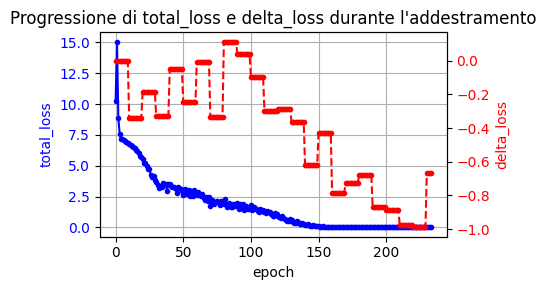

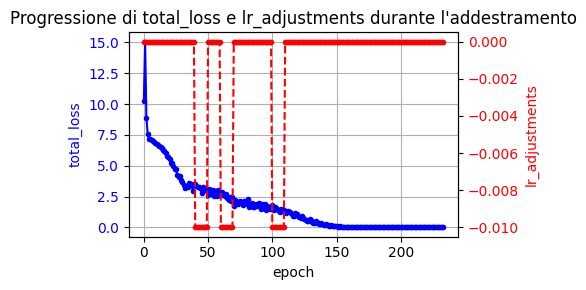

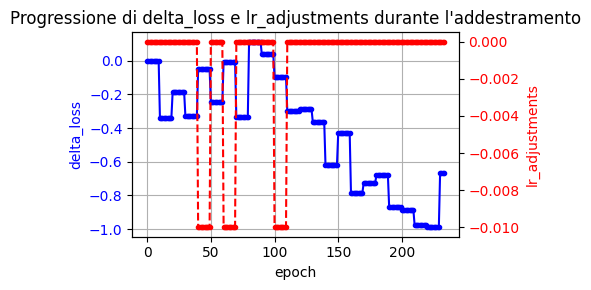

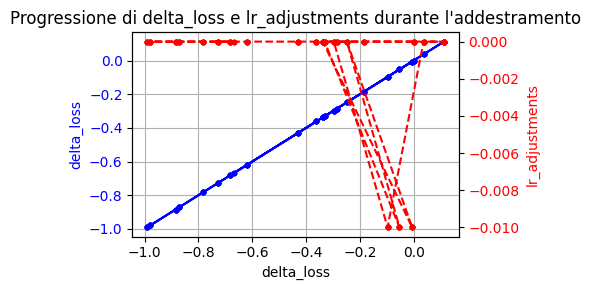

'\nacceptable_inputs = {tuple(x) for x, _ in data}\nstr_acceptable_inputs = ",".join(f"({int(pair[0])}, {int(pair[1])})" for pair in acceptable_inputs)\nstr_acceptable_inputs = \'\'.join(str_acceptable_inputs)\nprint(f"acceptable_inputs: {acceptable_inputs}")\n\n# Funzione per raccogliere e validare l\'input dell\'utente\ndef get_user_input():\n    while True:\n        try:\n            # Raccogli input dell\'utente come stringa\n#            user_input = input(f"Inserisci due numeri tra i seguenti separati da spazio {str_acceptable_inputs}: ")\n            user_input = \'1 0\'\n            # Converti la stringa in una lista di float\n            user_input_list = list(map(float, user_input.split()))\n            # Verifica se l\'input è una coppia di valori\n            if len(user_input_list) != 2:\n                print("Devi inserire esattamente due valori.")\n                continue\n            # Convertilo in una tupla\n            user_input_tuple = tuple(user_input_list)\n   

In [136]:
from os import stat
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from graphviz import Digraph
import pdb
import sys

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        if not isinstance(data, (int, float)):
          raise TypeError("data must be a scalar (int or float)")
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): #-self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, nm={self._nm})"


def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


import random

#--------------------------------------------------------
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
#        return out[0] if len(out) == 1 else out
        return out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

  # a simple 2D neuron
import random

data = [
    ([0.0, 0.0], 0.0),  # XOR(0, 0) = 0
    ([0.0, 1.0], 1.0),  # XOR(0, 1) = 1
    ([1.0, 0.0], 1.0),  # XOR(1, 0) = 1
    ([1.0, 1.0], 0.0),  # XOR(1, 1) = 0
    ([2.0, 0.0], 1.2),  # PDOR(2,0) = 1.2
    ([2.0, 1.0], 1.3),  # PDOR(2,1) = 1.3
    ([2.0, 2.0], 1.4),  # PDOR(2,2) = 1.4
    ([0.0, 2.0], 1.7),  # PDOR(0,2) = 1.7
    ([3.0, 0.0], 3.0),  # PDOR(0,2) = 3.0
    ([3.0, 1.0], 0.31)  # PDOR(0,31) = 0.31
]

# Creazione della rete neurale
# Rete con 2 input, uno strato nascosto con 10 neuroni, e un output singolo
mlp = MLP(2, [10, 5, 1])

# Funzione di perdita (MSE - Mean Squared Error)
def loss_function(pred, target):
    return (pred - target)**2

#colleziona i dati  necessari per calcoli o grafici lungo ogni step di esecuzione

class my_data_collection:

  def __init__(self):
    self._data = []

  def collect_data(self, *args):
    if len(args) == 1:
      self._data.append(args[0])
    else:
      self._data.append(tuple(args))

my_data = my_data_collection()

# genera i grafici sulla base dei dati collezionati
def show_graph(x, x_lable, y1, y1_lable, y2, y2_lable, y1_is_x = False):
  if y1_is_x:
    x = y1
    x_lable = y1_lable

  # Creare il grafico
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(x, y1, marker='.', linestyle='-', color='b', label=y1_lable)
  ax1.set_xlabel(x_lable)
  ax1.set_ylabel(y1_lable, color='b')
  ax1.tick_params(axis='y', labelcolor='b')
  ax1.grid(True)
  # asse y secondario
  ax2 = ax1.twinx()
  ax2.plot(x, y2, marker='.', linestyle='--', color='r', label=y2_lable)
  ax2.set_ylabel(y2_lable, color='r')
  ax2.tick_params(axis='y', labelcolor='r')
  # Titolo e legende
  plt.title(f'Progressione di {y1_lable} e {y2_lable} durante l\'addestramento')
  fig.tight_layout()
  plt.show()


#learning rate modulation based on an input representing the delta_loss between an iteration and another

def lr_adjustment(delta_loss, adj_magnitude = 0, offset = 0, non_linear = True):
  lr_adj = 0
  #print(f"total_loss: {total_loss}, loss.data: {loss.data}, delta: {(total_loss-loss.data)/total_loss}, delta_loss: {delta_loss}")
  if non_linear:
    if (delta_loss >= offset): lr_adj =  adj_magnitude*np.tanh(10 * delta_loss)
    elif (-offset <= delta_loss < 0): lr_adj = adj_magnitude*np.tanh(1/(1 * delta_loss))
  else:
    if (delta_loss >= offset): lr_adj = adj_magnitude
    elif (-offset <= delta_loss < 0): lr_adj = -adj_magnitude
  return lr_adj

# Addestramento della rete
np.random.seed(1337)
random.seed(1337)
iterations = 300
initial_learning_rate = 0.03
learning_rate = initial_learning_rate
delta_loss = 0
lr_adj = 0
new_lr = initial_learning_rate


for epoch in range(iterations):  # Iterazioni dell'addestramento
    total_loss = 0
    for x, y in data:
        # Conversione degli input in oggetti Value
        inputs = [Value(xi) for xi in x]
        target = Value(y)

        # Passaggio in avanti
        pred = mlp(inputs)
        if isinstance(pred, list):
          pred = pred[0]

        # Calcolo della perdita
        loss = loss_function(pred, target)
        total_loss += loss.data


        # Retropropagazione
        mlp.zero_grad()  # Azzera i gradienti accumulati
        loss.backward()  # Calcola i gradienti

       # Aggiornamento dei parametri
        for p in mlp.parameters():
            p.data -= learning_rate * p.grad

   # **Interruzione del ciclo se la loss totale è zero**
    if total_loss < 0.000000001:
      print("Addestramento completato: la loss totale è zero.")
      print(f"Epoch {epoch}, learning rate: {learning_rate:.4f}, total_loss: {total_loss:.9f}, iterations: {iterations}")
      break

   # modulazione del learning rate ogni 10 epoche in base al valore di total_loss
    if (epoch % 10 == 0):
        if (epoch != 0):
         delta_loss = ((total_loss - my_data._data[epoch-10][1])/my_data._data[epoch-10][1])
         lr_adj = lr_adjustment(delta_loss, adj_magnitude = 0.01, offset = 0.15)
         learning_rate *= (1 + lr_adj)
         #print(f"Epoch {epoch} su {iterations}, total_loss: {total_loss:.4f}, delta_loss: {delta_loss:.4f}, lr_adj: {lr_adj:.4f}, lr: {learning_rate:.4f} ")
    #cumulo i dati per graficarli successivamente
    my_data.collect_data(epoch, total_loss, learning_rate, delta_loss, lr_adj)


# Test della rete neurale
print("\nTest della rete neurale:")
for x, y in data:
    inputs = [Value(xi) for xi in x]
    pred = mlp(inputs)[0].data
    print(f"Input: {x}, Predicted: {pred:.4f}, Actual: {y}")

# Separare i dati collezionatio per i grafici
epochs, losses, learning_rates, delta_losses, lr_adjs = zip(*my_data._data)

# Disegna il grafico

show_graph (epochs, 'epoch', losses, 'total_loss', learning_rates, 'learning_rate')
show_graph (epochs, 'epoch', losses, 'total_loss', delta_losses, 'delta_loss')
show_graph (epochs, 'epoch', losses, 'total_loss', lr_adjs, 'lr_adjustments')
show_graph (epochs, 'epoch', delta_losses, 'delta_loss', lr_adjs, 'lr_adjustments')
show_graph (epochs, 'epoch', delta_losses, 'delta_loss', lr_adjs, 'lr_adjustments', y1_is_x = True)

# uso del modello
#print ('USO DEL MODELLO-------------')
"""
acceptable_inputs = {tuple(x) for x, _ in data}
str_acceptable_inputs = ",".join(f"({int(pair[0])}, {int(pair[1])})" for pair in acceptable_inputs)
str_acceptable_inputs = ''.join(str_acceptable_inputs)
print(f"acceptable_inputs: {acceptable_inputs}")

# Funzione per raccogliere e validare l'input dell'utente
def get_user_input():
    while True:
        try:
            # Raccogli input dell'utente come stringa
#            user_input = input(f"Inserisci due numeri tra i seguenti separati da spazio {str_acceptable_inputs}: ")
            user_input = '1 0'
            # Converti la stringa in una lista di float
            user_input_list = list(map(float, user_input.split()))
            # Verifica se l'input è una coppia di valori
            if len(user_input_list) != 2:
                print("Devi inserire esattamente due valori.")
                continue
            # Convertilo in una tupla
            user_input_tuple = tuple(user_input_list)
            # Verifica se la coppia è valida
            if user_input_tuple in acceptable_inputs:
                print(f"La coppia {user_input_tuple} è valida.")
                break
            else:
                print(f"La coppia {user_input_tuple} non è valida. Riprova.")
        except ValueError:
            print("Input non valido. Assicurati di inserire numeri separati da spazio.")
    return user_input_tuple
# Chiamata alla funzione
inputs = get_user_input()
print(' inputs',inputs)
value_inputs = [Value(xi) for xi in inputs]
pred = mlp(value_inputs)[0].data
print(f"Predicted:{pred:.4f}")
"""
